---
# 0602
기홍님이 올린 코드에서 base로 내코드 작성하기

희연 : path 2 까지 한 것 +   
각도 많이 꺾는 지점에서 STOP - Turn - move +  
같은 자리를 빙글빙글 돌 경우 일정 시간 줘서 그 자리에서 계속 있으면, 처음 계산한 A* 최단 경로에서 각도 꺾이는 부분까지 이동 후, 다시 A* 지속해서 업데이트 한 길 따라가기

---

https://github.com/sharesugi/ready/blob/kihong/%EC%9E%90%EC%9C%A8%EC%A3%BC%ED%96%89%20%ED%8C%8C%ED%8A%B8/kihong/Astar_tank_gpt_10.py

희연님이 base로 사용할 코드 🔼


---
# path 2개 이동 후 현위치, 최종목적지 이동 재계산 추가

In [15]:
# path 2개 이동후 재계산 추가_ 희연
# 장애물 근접시 속도 줄이기 추가_김기홍님
# Flask 및 필요한 라이브러리 불러오기
from flask import Flask, request, jsonify
from queue import PriorityQueue
import os
import torch
from ultralytics import YOLO
import math
import cv2
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import json

# Flask 앱 초기화 및 YOLO 모델 로드
app = Flask(__name__)
model = YOLO('yolov8n.pt')

# 전역 설정값 및 변수 초기화
GRID_SIZE = 300  # 맵 크기
maze = [[0 for _ in range(GRID_SIZE)] for _ in range(GRID_SIZE)]  # 장애물 맵

# 내 전차 시작 위치
start_x = 50
start_z = 50
start = (start_x, start_z)
# 최종 목적지 위치 - 적 전차도 이 위치에 갖다 놓음.
destination_x = 150
destination_z = 275
destination = (destination_x, destination_z)
print(f"🕜️ 초기 destination 설정: {destination}")

INITIAL_YAW = 90.0  # 초기 YAW 값 - 맨 처음 전차의 방향이 0도이기 때문에 0.0 줌. 이를  
current_yaw = INITIAL_YAW  # 현재 차체 방향 추정치 -> playerBodyX로 바꾸면 좋겠으나 실패... playerBodyX의 정보를 받아 오는데 딜레이가 걸린다면 지금처럼 current_yaw값 쓰는게 좋다고 함(by GPT)
previous_position = None  # 이전 위치 (yaw 계산용)
target_reached = False  # 목표 도달 유무 플래그
current_angle = 0.0  # 실제 플레이어의 차체 각도 저장용 (degree) -> playerBodyX 받아오는 방법 사용해 볼 것임.

# 시각화 관련 부분

# 이동 경로 그림 그릴 때 필요함.
current_position = None
last_position = None
position_history = []

# A* 알고리즘 관련 클래스 및 함수 정의
class Node:
    def __init__(self, position, parent=None):
        self.position = position
        self.parent = parent
        self.g = 0
        self.h = 0
        self.f = 0
    def __lt__(self, other):
        return self.f < other.f

def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def get_neighbors(pos):
    neighbors = []
    for dx, dz in [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]:
        x, z = pos[0] + dx, pos[1] + dz
        if 0 <= x < GRID_SIZE and 0 <= z < GRID_SIZE:
            # 대각선 이동일 경우 추가 확인
            if dx != 0 and dz != 0:
                if maze[pos[1]][x] == 1 or maze[z][pos[0]] == 1:
                    continue  # 대각선 경로에 인접한 직선 중 하나라도 막혀있으면 skip # 즉 모서리를 못 뚫고 지나가게 수정
            if maze[z][x] == 0: 
                neighbors.append((x, z))
    return neighbors

def a_star(start, goal):
    open_set = PriorityQueue()
    open_set.put((0, Node(start)))
    closed = set()
    while not open_set.empty():
        _, current = open_set.get()
        if current.position == goal:
            path = []
            while current:
                path.append(current.position)
                current = current.parent
            return path[::-1]
        closed.add(current.position)
        for nbr in get_neighbors(current.position):
            if nbr in closed: continue
            node = Node(nbr, current)
            node.g = current.g + 1
            node.h = heuristic(nbr, goal)
            node.f = node.g + node.h
            open_set.put((node.f, node))
    return [start]

path = a_star(start, destination)  # 현재 A* 결과

# 현재 위치와 다음 위치 간 각도 계산 함수
def calculate_angle(current, next_pos): # A*알고리즘을 통해서 어디로 갈지 전체 경로를 정했기 때문에 다음 위치로만 가면 됨.
    dx = next_pos[0] - current[0]
    dz = next_pos[1] - current[1]
    return (math.degrees(math.atan2(dz, dx)) + 360) % 360

# 전방 장애물 감지 함수_ 기홍님 추가 _0602_ 아침에 깃허브에서 받음
# 함수 설명:이동하기 전에, 지금 위치와 현재 바라보는 방향(yaw)을 기준으로 
# 앞으로 radius만큼 한 칸씩 쭉 살펴봐서, 장애물(maze에서 1로 표시된 곳)이 있으면 미리 감지. 
# 그래서 아직 이동하지 않았어도 앞으로 막히는지 미리 확인 가능.
def is_obstacle_ahead(pos, yaw, maze, radius=30):
    """
    현재 yaw(도 단위) 방향 기준 전방 radius만큼 검사.
    장애물(maze=1)이 있으면 True 리턴.
    """
    x, z = pos   # 현좌표
    rad = math.radians(yaw)   # 현각도 라디안으로 변경
    dx = math.cos(rad)       
    dz = math.sin(rad)

    for step in range(1, radius + 1):
        nx = int(round(x + dx * step))
        nz = int(round(z + dz * step))
        if 0 <= nx < GRID_SIZE and 0 <= nz < GRID_SIZE:
            if maze[nz][nx] == 1:
                print(f"⚠️ 전방 장애물 감지: ({nx},{nz})")
                return True
    return False


# 장애물 맵 유효 위치 확인
def is_valid_pos(pos, size=GRID_SIZE): # 장애물이 300x300 안에 있는지 확인
    x, z = pos
    return 0 <= x < size and 0 <= z < size

# Flask API 라우팅 시작
@app.route('/init', methods=['GET'])
def init():
    global current_yaw, previous_position, target_reached
    current_yaw = INITIAL_YAW
    previous_position = None
    target_reached = False

    config = {
        "startMode": "start",
        "blStartX": start_x, "blStartY": 10, "blStartZ": start_z,
        "rdStartX": destination_x, "rdStartY": 10, "rdStartZ": destination_z,
        "trackingMode": False, "detectMode": False, "logMode": False,
        "enemyTracking": False, "saveSnapshot": False,
        "saveLog": False, "saveLidarData": False, "lux": 30000
    }
    print("🛠️ /init config:", config)
    return jsonify(config)

# 여기 리스트에 cmd 2개를 넣는다
combined_command_cache = []

@app.route('/get_action', methods=['POST'])
def get_action():
    global target_reached, previous_position, current_yaw, current_position, last_position
    data = request.get_json(force=True)
    pos = data.get('position', {})
    pos_x = float(pos.get('x', 0))
    pos_z = float(pos.get('z', 0))

    if not target_reached and math.hypot(pos_x - destination[0], pos_z - destination[1]) < 5.0:
        target_reached = True
        print("✨ 목표 도달: 전차 정지 플래그 설정")
        
    if target_reached:
        stop_cmd = {k: {'command': 'STOP', 'weight': 1.0} for k in ['moveWS', 'moveAD']}
        return jsonify(stop_cmd)

    if previous_position is not None:
        dx = pos_x - previous_position[0]
        dz = pos_z - previous_position[1]
        if math.hypot(dx, dz) > 0.01:
            current_yaw = (math.degrees(math.atan2(dz, dx)) + 360) % 360
    previous_position = (pos_x, pos_z)

    current_grid = (int(pos_x), int(pos_z))
    path = a_star(current_grid, destination)

    ####################### 여기서부터 해보기 (희연)################################################################
    # 2 좌표 이동한 후. astar(현좌표, 최종목적지) 함수 실행해서 path 새로 뽑기 반복

    # 예전 코드
    # next_grid = path[1] if len(path) > 1 else current_grid

    if combined_command_cache:
    # 캐시에 남은 명령이 있으면 그걸 먼저 보내고 pop
        cmd = combined_command_cache.pop(0)
        return jsonify(cmd)

    
    if len(path) > 2:   # 최종목적지까지 3개 이상의 좌표가 남았으면 
        next_grid = path[1:3]  # 두번째 좌표 참조
    elif len(path) > 1:          # 최종목적지까지 2개 이하의 좌표가 남았으면 
        next_grid = [path[1]]      # 한개씩 참조  
    else: 
        next_grid = current_grid   # 0개면 멈춰라! 도착한거니까!

    for i in range(len(next_grid)):  # 두개의 좌표가 맵을 빠져나기지 않는지 확인 # 0, 1

        # next_grid[1]의 회전 각도는 current 가 아니라 next_grid[0]에서 게산해야 맞음 
        base_pos = current_grid if i == 0 else next_grid[i - 1]  
    
        if not is_valid_pos(next_grid[i]):  # 가야하는 곳이 맵 외에 있으면 움직이는거 멈춤
            stop_cmd = {k: {'command': '', 'weight': 0.0} for k in ['moveWS', 'moveAD']}
            stop_cmd['fire'] = False
            return jsonify(stop_cmd)

        target_angle = calculate_angle(base_pos, next_grid[i])  # 현재 좌표에서 두번째 좌표로
        diff = (target_angle - current_yaw + 360) % 360   # 현 각도랑 틀어야할 각도 차이 알아내고
        if diff > 180:  # 이거는 정규화 비슷
            diff -= 360

        # 이건 그냥 유클리드 거리. sqrt는 제곱근! 현위치랑 목적좌표까지의 거리 
        distance = math.sqrt((pos_x - destination[0])**2 + (pos_z - destination[1])**2)

        # 전방 장애물 감지 _ 기홍님이 새로 추가 0602_ 오늘 아침에 깃허브에서 받음
        ahead_obstacle = is_obstacle_ahead(base_pos, current_yaw, maze)

        if distance < 50 :   # 앞으로 가는 weight
            w_weight = 0.2
            acceleration = 'S'
        elif ahead_obstacle:
            w_weight = 0.2  # 전방에 장애물 있을 경우 감속
            acceleration = 'S'
        else:
            w_weight = 0.5
            acceleration = 'W'


        # 각도가 많이 꺾이면 멈췄다가 가기_희연 
        #여기에 추가로 stop을 넣어야함.
        abs_diff = abs(diff)
        stop = 30 <= abs_diff # 틀어야하는 각도가 30도 이상이면 stop 은 true! 그 아래면 false!!

        if 0 < abs_diff < 30 :  
            w_degree = 0.3
        elif 30 <= abs_diff < 60 :    
            w_degree = 0.6
            stop = True
        elif 60 <= abs_diff < 90 : 
            w_degree = 0.75
        else :
            w_degree = 1.0
    
        forward = {'command': acceleration, 'weight': w_weight}
        turn = {'command': 'A' if diff > 0 else 'D', 'weight': w_degree}

        cmd = {
            'moveWS': forward,
            'moveAD': turn
        }

        combined_command_cache.append(cmd)   # 두 좌표에 대한 명령값 2개가 여기 리스트에 저장됨

    # 처음 1회 A* 경로 계산_ 기홍님이 새로 추가
    if len(position_history) == 0:
        path = a_star((int(pos_x), int(pos_z)), destination)  # 현 위치에서 최종 목적지까지 다시 계산
        df = pd.DataFrame(path, columns=["x", "z"])
        df.to_csv("a_star_path.csv", index=False)

    
    if current_grid:
        last_position = current_grid
    position_history.append(current_grid)
    
    df = pd.DataFrame(position_history, columns=["x", "z"])
    df.to_csv("tank_path0.csv", index=False)


    # print문 살짝 수정-희연
    print(f"📍 현재 pos=({pos_x:.1f},{pos_z:.1f}) yaw={current_yaw:.1f} 두번째 좌표로 가는 앵글 ={target_angle:.1f} 차이 ={diff:.1f}")
    print(f"🚀 cmd 2개 {combined_command_cache}")
    return jsonify(combined_command_cache.pop(0))



@app.route('/set_destination', methods=['POST'])
def set_destination():
    global destination
    data = request.get_json()
    if not data or 'destination' not in data:
        return jsonify({'status': 'ERROR', 'message': 'Missing destination'}), 400
    try:
        x, y, z = map(float, data['destination'].split(','))
        destination = (int(x), int(z))
        print(f"🎯 destination set to: {destination}")
        return jsonify({'status': 'OK', 'destination': {'x': x, 'y': y, 'z': z}})
    except Exception as e:
        return jsonify({'status': 'ERROR', 'message': str(e)}), 400

@app.route('/start', methods=['GET'])
def start():
    print('start')
    return jsonify({'control': ''})

@app.route('/collision', methods=['POST'])
def collision():
    d = request.get_json(force=True)
    obj = d.get('objectName')
    p = d.get('position', {})
    print(f"Collision {obj} at ({p.get('x')},{p.get('y')},{p.get('z')})")
    return jsonify({'status': 'success', 'message': 'Collision received'})


original_obstacles = []  # 원본 장애물 좌표 저장용 (버퍼 없이)

@app.route('/update_obstacle', methods=['POST'])
def update_obstacle():
    global maze, original_obstacles
    data = request.get_json(force=True)

    obstacles = data.get("obstacles", [])
    print(f"🪨 장애물 업데이트 요청: {len(obstacles)}개")

    for obs in obstacles:
        try:
            # 원본 좌표 저장 (시각화용)
            original_obstacles.append({
                "x_min": int(obs["x_min"]),
                "x_max": int(obs["x_max"]),
                "z_min": int(obs["z_min"]),
                "z_max": int(obs["z_max"]),
            })

            # A* 계산용 좌표는 buffer 포함
            buffer = 7
            x_min = max(0, int(obs["x_min"]) - buffer)
            x_max = min(GRID_SIZE - 1, int(obs["x_max"]) + buffer)
            z_min = max(0, int(obs["z_min"]) - buffer)
            z_max = min(GRID_SIZE - 1, int(obs["z_max"]) + buffer)

            for x in range(x_min, x_max + 1):
                for z in range(z_min, z_max + 1):
                    maze[z][x] = 1

        except KeyError as e:
            print(f"❌ 누락된 키: {e}")

    # 장애물 저장 (옵션)
    np.save("maze.npy", np.array(maze))
    np.savetxt("maze.csv", np.array(maze), fmt="%d", delimiter=",")

    # ✅ 원본 장애물 저장
    try:
        json_path = os.path.join(os.path.dirname(__file__), "original_obstacles.json")
        with open(json_path, "w") as f:
            json.dump(original_obstacles, f, indent=2)
        print("✅ original_obstacles.json 저장 완료!")
    except Exception as e:
        print(f"❌ JSON 저장 실패: {e}")

    return jsonify({"status": "OK", "count": len(obstacles)})



@app.route('/info', methods=['POST'])
def info():
    data = request.get_json(force=True)
    if not data:
        return jsonify({"error": "No JSON received"}), 400

    # 전체 구조 출력 (디버그용)
    # print("📨 /info data received:", data)

    # playerBodyX에서 각도 추출
    global current_angle
    current_angle = float(data.get("playerBodyX", current_angle))

    return jsonify({"status": "success"})

# 서버 실행
if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)



🕜️ 초기 destination 설정: (150, 275)
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.26.45.58:5000
Press CTRL+C to quit
127.0.0.1 - - [02/Jun/2025 12:34:20] "GET /init HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:20] "POST /update_obstacle HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:20] "POST /update_obstacle HTTP/1.1" 200 -


🪨 장애물 업데이트 요청: 0개
🪨 장애물 업데이트 요청: 0개
🛠️ /init config: {'startMode': 'start', 'blStartX': 50, 'blStartY': 10, 'blStartZ': 50, 'rdStartX': 150, 'rdStartY': 10, 'rdStartZ': 275, 'trackingMode': False, 'detectMode': False, 'logMode': False, 'enemyTracking': False, 'saveSnapshot': False, 'saveLog': False, 'saveLidarData': False, 'lux': 30000}
❌ JSON 저장 실패: name '__file__' is not defined
❌ JSON 저장 실패: name '__file__' is not defined


127.0.0.1 - - [02/Jun/2025 12:34:23] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(50.0,50.0) yaw=90.0 두번째 좌표로 가는 앵글 =45.0 차이 =-45.0
🚀 cmd 2개 [{'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'D', 'weight': 0.6}}, {'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'D', 'weight': 0.6}}]


127.0.0.1 - - [02/Jun/2025 12:34:24] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:24] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(50.2,50.6) yaw=70.5 두번째 좌표로 가는 앵글 =45.0 차이 =-25.5
🚀 cmd 2개 [{'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'D', 'weight': 0.3}}, {'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'D', 'weight': 0.3}}]


127.0.0.1 - - [02/Jun/2025 12:34:25] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:25] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(51.3,52.4) yaw=54.9 두번째 좌표로 가는 앵글 =45.0 차이 =-9.9
🚀 cmd 2개 [{'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'D', 'weight': 0.3}}, {'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'D', 'weight': 0.3}}]


127.0.0.1 - - [02/Jun/2025 12:34:26] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:26] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(53.7,54.8) yaw=42.4 두번째 좌표로 가는 앵글 =45.0 차이 =2.6
🚀 cmd 2개 [{'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'A', 'weight': 0.3}}, {'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'A', 'weight': 0.3}}]


127.0.0.1 - - [02/Jun/2025 12:34:27] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:27] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(57.4,58.4) yaw=47.0 두번째 좌표로 가는 앵글 =45.0 차이 =-2.0
🚀 cmd 2개 [{'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'D', 'weight': 0.3}}, {'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'D', 'weight': 0.3}}]


127.0.0.1 - - [02/Jun/2025 12:34:28] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:28] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(61.9,62.8) yaw=41.7 두번째 좌표로 가는 앵글 =45.0 차이 =3.3
🚀 cmd 2개 [{'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'A', 'weight': 0.3}}, {'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'A', 'weight': 0.3}}]


127.0.0.1 - - [02/Jun/2025 12:34:29] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:29] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(67.4,68.1) yaw=47.0 두번째 좌표로 가는 앵글 =45.0 차이 =-2.0
🚀 cmd 2개 [{'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'D', 'weight': 0.3}}, {'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'D', 'weight': 0.3}}]


127.0.0.1 - - [02/Jun/2025 12:34:30] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:31] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(73.8,74.5) yaw=41.6 두번째 좌표로 가는 앵글 =45.0 차이 =3.4
🚀 cmd 2개 [{'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'A', 'weight': 0.3}}, {'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'A', 'weight': 0.3}}]


127.0.0.1 - - [02/Jun/2025 12:34:31] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:32] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(81.2,81.5) yaw=46.9 두번째 좌표로 가는 앵글 =45.0 차이 =-1.9
🚀 cmd 2개 [{'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'D', 'weight': 0.3}}, {'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'D', 'weight': 0.3}}]


127.0.0.1 - - [02/Jun/2025 12:34:32] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:33] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(88.7,89.2) yaw=42.2 두번째 좌표로 가는 앵글 =45.0 차이 =2.8
🚀 cmd 2개 [{'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'A', 'weight': 0.3}}, {'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'A', 'weight': 0.3}}]


127.0.0.1 - - [02/Jun/2025 12:34:33] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:34] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(96.1,96.4) yaw=47.3 두번째 좌표로 가는 앵글 =45.0 차이 =-2.3
🚀 cmd 2개 [{'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'D', 'weight': 0.3}}, {'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'D', 'weight': 0.3}}]


127.0.0.1 - - [02/Jun/2025 12:34:34] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:35] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(103.4,103.7) yaw=42.2 두번째 좌표로 가는 앵글 =45.0 차이 =2.8
🚀 cmd 2개 [{'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'A', 'weight': 0.3}}, {'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'A', 'weight': 0.3}}]


127.0.0.1 - - [02/Jun/2025 12:34:35] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:36] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(110.8,110.9) yaw=47.3 두번째 좌표로 가는 앵글 =45.0 차이 =-2.3
🚀 cmd 2개 [{'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'D', 'weight': 0.3}}, {'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'D', 'weight': 0.3}}]


127.0.0.1 - - [02/Jun/2025 12:34:36] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:37] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(118.1,118.3) yaw=42.1 두번째 좌표로 가는 앵글 =45.0 차이 =2.9
🚀 cmd 2개 [{'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'A', 'weight': 0.3}}, {'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'A', 'weight': 0.3}}]


127.0.0.1 - - [02/Jun/2025 12:34:38] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:38] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(125.5,125.5) yaw=47.3 두번째 좌표로 가는 앵글 =45.0 차이 =-2.3
🚀 cmd 2개 [{'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'D', 'weight': 0.3}}, {'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'D', 'weight': 0.3}}]


127.0.0.1 - - [02/Jun/2025 12:34:39] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:39] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(132.8,132.8) yaw=42.1 두번째 좌표로 가는 앵글 =45.0 차이 =2.9
🚀 cmd 2개 [{'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'A', 'weight': 0.3}}, {'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'A', 'weight': 0.3}}]


127.0.0.1 - - [02/Jun/2025 12:34:40] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:40] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(140.2,140.1) yaw=47.3 두번째 좌표로 가는 앵글 =45.0 차이 =-2.3
🚀 cmd 2개 [{'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'D', 'weight': 0.3}}, {'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'D', 'weight': 0.3}}]


127.0.0.1 - - [02/Jun/2025 12:34:41] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:41] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(147.5,147.4) yaw=42.1 두번째 좌표로 가는 앵글 =45.0 차이 =2.9
🚀 cmd 2개 [{'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'A', 'weight': 0.3}}, {'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'A', 'weight': 0.3}}]


127.0.0.1 - - [02/Jun/2025 12:34:42] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:42] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(154.9,154.6) yaw=47.3 두번째 좌표로 가는 앵글 =135.0 차이 =87.7
🚀 cmd 2개 [{'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'A', 'weight': 0.75}}, {'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'A', 'weight': 0.75}}]


127.0.0.1 - - [02/Jun/2025 12:34:43] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:43] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(159.2,163.9) yaw=73.6 두번째 좌표로 가는 앵글 =135.0 차이 =61.4
🚀 cmd 2개 [{'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'A', 'weight': 0.75}}, {'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'A', 'weight': 0.75}}]


127.0.0.1 - - [02/Jun/2025 12:34:44] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:44] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(157.8,174.1) yaw=105.6 두번째 좌표로 가는 앵글 =135.0 차이 =29.4
🚀 cmd 2개 [{'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'A', 'weight': 0.3}}, {'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'A', 'weight': 0.3}}]


127.0.0.1 - - [02/Jun/2025 12:34:45] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:46] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(152.5,183.0) yaw=124.1 두번째 좌표로 가는 앵글 =135.0 차이 =10.9
🚀 cmd 2개 [{'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'A', 'weight': 0.3}}, {'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'A', 'weight': 0.3}}]


127.0.0.1 - - [02/Jun/2025 12:34:46] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:47] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(145.3,190.4) yaw=137.0 두번째 좌표로 가는 앵글 =45.0 차이 =-92.0
🚀 cmd 2개 [{'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'D', 'weight': 1.0}}, {'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'D', 'weight': 1.0}}]


127.0.0.1 - - [02/Jun/2025 12:34:47] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:48] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(140.1,199.1) yaw=110.8 두번째 좌표로 가는 앵글 =45.0 차이 =-65.8
🚀 cmd 2개 [{'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'D', 'weight': 0.75}}, {'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'D', 'weight': 0.75}}]


127.0.0.1 - - [02/Jun/2025 12:34:48] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:49] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(141.2,209.3) yaw=75.5 두번째 좌표로 가는 앵글 =45.0 차이 =-30.5
🚀 cmd 2개 [{'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'D', 'weight': 0.6}}, {'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'D', 'weight': 0.6}}]


127.0.0.1 - - [02/Jun/2025 12:34:49] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:50] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(147.2,217.7) yaw=48.1 두번째 좌표로 가는 앵글 =45.0 차이 =-3.1
🚀 cmd 2개 [{'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'D', 'weight': 0.3}}, {'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'D', 'weight': 0.3}}]


127.0.0.1 - - [02/Jun/2025 12:34:50] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:51] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(155.7,223.5) yaw=31.4 두번째 좌표로 가는 앵글 =135.0 차이 =103.6
🚀 cmd 2개 [{'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'A', 'weight': 1.0}}, {'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'A', 'weight': 1.0}}]


127.0.0.1 - - [02/Jun/2025 12:34:51] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:52] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(162.6,230.9) yaw=57.6 두번째 좌표로 가는 앵글 =135.0 차이 =77.4
🚀 cmd 2개 [{'moveWS': {'command': 'S', 'weight': 0.2}, 'moveAD': {'command': 'A', 'weight': 0.75}}, {'moveWS': {'command': 'S', 'weight': 0.2}, 'moveAD': {'command': 'A', 'weight': 0.75}}]


127.0.0.1 - - [02/Jun/2025 12:34:52] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:53] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(163.6,240.9) yaw=92.8 두번째 좌표로 가는 앵글 =135.0 차이 =42.2
🚀 cmd 2개 [{'moveWS': {'command': 'S', 'weight': 0.2}, 'moveAD': {'command': 'A', 'weight': 0.6}}, {'moveWS': {'command': 'S', 'weight': 0.2}, 'moveAD': {'command': 'A', 'weight': 0.6}}]


127.0.0.1 - - [02/Jun/2025 12:34:54] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:54] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(159.7,249.5) yaw=120.3 두번째 좌표로 가는 앵글 =135.0 차이 =14.7
🚀 cmd 2개 [{'moveWS': {'command': 'S', 'weight': 0.2}, 'moveAD': {'command': 'A', 'weight': 0.3}}, {'moveWS': {'command': 'S', 'weight': 0.2}, 'moveAD': {'command': 'A', 'weight': 0.3}}]


127.0.0.1 - - [02/Jun/2025 12:34:55] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:55] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(153.5,256.0) yaw=136.9 두번째 좌표로 가는 앵글 =135.0 차이 =-1.9
🚀 cmd 2개 [{'moveWS': {'command': 'S', 'weight': 0.2}, 'moveAD': {'command': 'D', 'weight': 0.3}}, {'moveWS': {'command': 'S', 'weight': 0.2}, 'moveAD': {'command': 'D', 'weight': 0.3}}]


127.0.0.1 - - [02/Jun/2025 12:34:56] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:56] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(147.6,262.0) yaw=131.7 두번째 좌표로 가는 앵글 =45.0 차이 =-86.7
🚀 cmd 2개 [{'moveWS': {'command': 'S', 'weight': 0.2}, 'moveAD': {'command': 'D', 'weight': 0.75}}, {'moveWS': {'command': 'S', 'weight': 0.2}, 'moveAD': {'command': 'D', 'weight': 0.75}}]


127.0.0.1 - - [02/Jun/2025 12:34:57] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:57] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(144.5,269.1) yaw=105.4 두번째 좌표로 가는 앵글 =45.0 차이 =-60.4
🚀 cmd 2개 [{'moveWS': {'command': 'S', 'weight': 0.2}, 'moveAD': {'command': 'D', 'weight': 0.75}}, {'moveWS': {'command': 'S', 'weight': 0.2}, 'moveAD': {'command': 'D', 'weight': 0.75}}]


127.0.0.1 - - [02/Jun/2025 12:34:58] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:58] "POST /get_action HTTP/1.1" 200 -


✨ 목표 도달: 전차 정지 플래그 설정


127.0.0.1 - - [02/Jun/2025 12:34:59] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:34:59] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:35:00] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:35:00] "GET /start HTTP/1.1" 200 -


start


127.0.0.1 - - [02/Jun/2025 12:35:01] "GET /start HTTP/1.1" 200 -


start


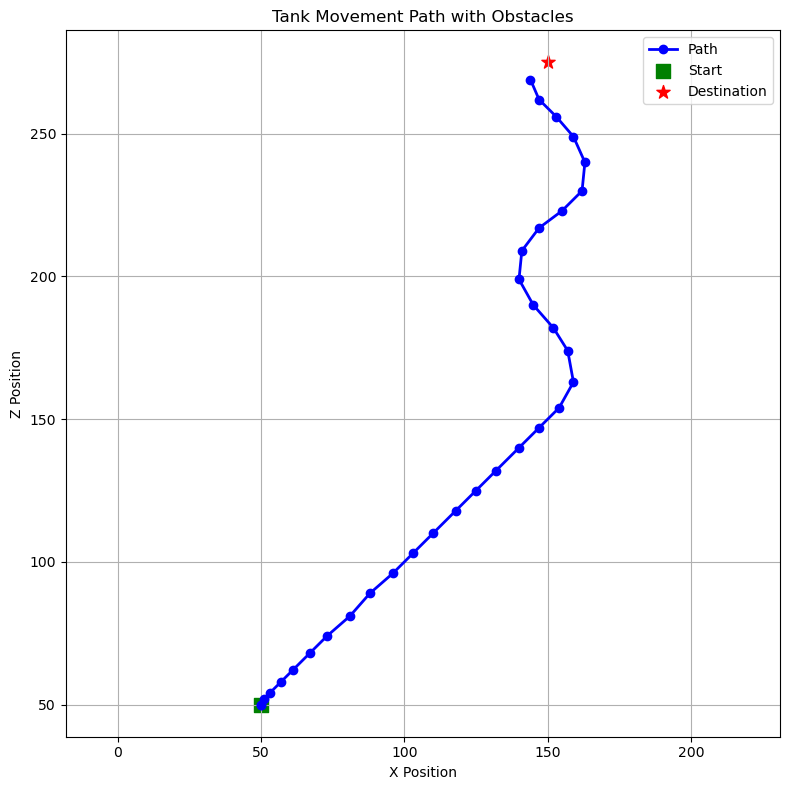

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

# 데이터 불러오기
df = pd.read_csv("tank_path0.csv")
maze = np.load("maze.npy")  # 저장된 장애물 정보
x_path = df["x"]
z_path = df["z"]

# 시작/도착 지점
start_x, start_z = 50, 50
destination_x, destination_z = 150, 275

plt.figure(figsize=(8, 8))

# 장애물 시각화
obstacle_coords = np.argwhere(maze == 1)
if len(obstacle_coords) > 0:
    obs_x = obstacle_coords[:, 0]
    obs_z = obstacle_coords[:, 1]
    plt.scatter(obs_x, obs_z, color='black', s=10, label="Obstacle")

# 이동 경로
plt.plot(x_path, z_path, marker='o', color='blue', linewidth=2, label="Path")

# 시작점/도착점
plt.scatter(start_x, start_z, color='green', s=100, label="Start", marker='s')
plt.scatter(destination_x, destination_z, color='red', s=100, label="Destination", marker='*')

# 마무리
plt.title("Tank Movement Path with Obstacles")
plt.xlabel("X Position")
plt.ylabel("Z Position")
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.savefig("tank_path_with_obstacles.png")
plt.show()


# 이동 경로 그림 그릴 때 필요함.
current_position = None
last_position = None
position_history = []

# /get action 안에 넣을 것

#     if current_grid:
#         last_position = current_grid
#     position_history.append(current_grid)
    
#     df = pd.DataFrame(position_history, columns=["x", "z"])
#     df.to_csv("tank_path0.csv", index=False)

---
# 멈추고 가는거 추가

In [19]:
# | 현각도 - 목표 각도| 값이 30 이상이면 멈췄다가감 추가_ 희연연
# path 2개 이동후 재계산 추가_ 희연
# 장애물 근접시 속도 줄이기 추가_김기홍님
from flask import Flask, request, jsonify
from queue import PriorityQueue
import os
import torch
from ultralytics import YOLO
import math
import cv2
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import json

# Flask 앱 초기화 및 YOLO 모델 로드
app = Flask(__name__)
model = YOLO('yolov8n.pt')

# 전역 설정값 및 변수 초기화
GRID_SIZE = 300  # 맵 크기
maze = [[0 for _ in range(GRID_SIZE)] for _ in range(GRID_SIZE)]  # 장애물 맵

# 내 전차 시작 위치
start_x = 50
start_z = 50
start = (start_x, start_z)
# 최종 목적지 위치 - 적 전차도 이 위치에 갖다 놓음.
destination_x = 150
destination_z = 275
destination = (destination_x, destination_z)
print(f"🕜️ 초기 destination 설정: {destination}")

INITIAL_YAW = 90.0  # 초기 YAW 값 - 맨 처음 전차의 방향이 0도이기 때문에 0.0 줌. 이를  
current_yaw = INITIAL_YAW  # 현재 차체 방향 추정치 -> playerBodyX로 바꾸면 좋겠으나 실패... playerBodyX의 정보를 받아 오는데 딜레이가 걸린다면 지금처럼 current_yaw값 쓰는게 좋다고 함(by GPT)
previous_position = None  # 이전 위치 (yaw 계산용)
target_reached = False  # 목표 도달 유무 플래그
current_angle = 0.0  # 실제 플레이어의 차체 각도 저장용 (degree) -> playerBodyX 받아오는 방법 사용해 볼 것임.

# 시각화 관련 부분

# 이동 경로 그림 그릴 때 필요함.
current_position = None
last_position = None
position_history = []

# A* 알고리즘 관련 클래스 및 함수 정의
class Node:
    def __init__(self, position, parent=None):
        self.position = position
        self.parent = parent
        self.g = 0
        self.h = 0
        self.f = 0
    def __lt__(self, other):
        return self.f < other.f

def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def get_neighbors(pos):
    neighbors = []
    for dx, dz in [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]:
        x, z = pos[0] + dx, pos[1] + dz
        if 0 <= x < GRID_SIZE and 0 <= z < GRID_SIZE:
            # 대각선 이동일 경우 추가 확인
            if dx != 0 and dz != 0:
                if maze[pos[1]][x] == 1 or maze[z][pos[0]] == 1:
                    continue  # 대각선 경로에 인접한 직선 중 하나라도 막혀있으면 skip # 즉 모서리를 못 뚫고 지나가게 수정
            if maze[z][x] == 0: 
                neighbors.append((x, z))
    return neighbors

def a_star(start, goal):
    open_set = PriorityQueue()
    open_set.put((0, Node(start)))
    closed = set()
    while not open_set.empty():
        _, current = open_set.get()
        if current.position == goal:
            path = []
            while current:
                path.append(current.position)
                current = current.parent
            return path[::-1]
        closed.add(current.position)
        for nbr in get_neighbors(current.position):
            if nbr in closed: continue
            node = Node(nbr, current)
            node.g = current.g + 1
            node.h = heuristic(nbr, goal)
            node.f = node.g + node.h
            open_set.put((node.f, node))
    return [start]

path = a_star(start, destination)  # 현재 A* 결과

# 현재 위치와 다음 위치 간 각도 계산 함수
def calculate_angle(current, next_pos): # A*알고리즘을 통해서 어디로 갈지 전체 경로를 정했기 때문에 다음 위치로만 가면 됨.
    dx = next_pos[0] - current[0]
    dz = next_pos[1] - current[1]
    return (math.degrees(math.atan2(dz, dx)) + 360) % 360

# 전방 장애물 감지 함수_ 기홍님 추가 _0602_ 아침에 깃허브에서 받음
# 함수 설명:이동하기 전에, 지금 위치와 현재 바라보는 방향(yaw)을 기준으로 
# 앞으로 radius만큼 한 칸씩 쭉 살펴봐서, 장애물(maze에서 1로 표시된 곳)이 있으면 미리 감지. 
# 그래서 아직 이동하지 않았어도 앞으로 막히는지 미리 확인 가능.
def is_obstacle_ahead(pos, yaw, maze, radius=30):
    """
    현재 yaw(도 단위) 방향 기준 전방 radius만큼 검사.
    장애물(maze=1)이 있으면 True 리턴.
    """
    x, z = pos   # 현좌표
    rad = math.radians(yaw)   # 현각도 라디안으로 변경
    dx = math.cos(rad)       
    dz = math.sin(rad)

    for step in range(1, radius + 1):
        nx = int(round(x + dx * step))
        nz = int(round(z + dz * step))
        if 0 <= nx < GRID_SIZE and 0 <= nz < GRID_SIZE:
            if maze[nz][nx] == 1:
                print(f"⚠️ 전방 장애물 감지: ({nx},{nz})")
                return True
    return False


# 장애물 맵 유효 위치 확인
def is_valid_pos(pos, size=GRID_SIZE): # 장애물이 300x300 안에 있는지 확인
    x, z = pos
    return 0 <= x < size and 0 <= z < size

# Flask API 라우팅 시작
@app.route('/init', methods=['GET'])
def init():
    global current_yaw, previous_position, target_reached
    current_yaw = INITIAL_YAW
    previous_position = None
    target_reached = False

    config = {
        "startMode": "start",
        "blStartX": start_x, "blStartY": 10, "blStartZ": start_z,
        "rdStartX": destination_x, "rdStartY": 10, "rdStartZ": destination_z,
        "trackingMode": False, "detectMode": False, "logMode": False,
        "enemyTracking": False, "saveSnapshot": False,
        "saveLog": False, "saveLidarData": False, "lux": 30000
    }
    print("🛠️ /init config:", config)
    return jsonify(config)

# 여기 리스트에 cmd 2개를 넣는다
combined_command_cache = []

@app.route('/get_action', methods=['POST'])
def get_action():
    global target_reached, previous_position, current_yaw, current_position, last_position
    data = request.get_json(force=True)
    pos = data.get('position', {})
    pos_x = float(pos.get('x', 0))
    pos_z = float(pos.get('z', 0))

    if not target_reached and math.hypot(pos_x - destination[0], pos_z - destination[1]) < 5.0:
        target_reached = True
        print("✨ 목표 도달: 전차 정지 플래그 설정")
        
    if target_reached:
        stop_cmd = {k: {'command': 'STOP', 'weight': 1.0} for k in ['moveWS', 'moveAD']}
        return jsonify(stop_cmd)

    if previous_position is not None:
        dx = pos_x - previous_position[0]
        dz = pos_z - previous_position[1]
        if math.hypot(dx, dz) > 0.01:
            current_yaw = (math.degrees(math.atan2(dz, dx)) + 360) % 360
    previous_position = (pos_x, pos_z)

    current_grid = (int(pos_x), int(pos_z))
    path = a_star(current_grid, destination)

    ####################### 여기서부터 해보기 (희연)################################################################
    # 2 좌표 이동한 후. astar(현좌표, 최종목적지) 함수 실행해서 path 새로 뽑기 반복

    # 예전 코드
    # next_grid = path[1] if len(path) > 1 else current_grid

    if combined_command_cache:
    # 캐시에 남은 명령이 있으면 그걸 먼저 보내고 pop
        cmd = combined_command_cache.pop(0)
        return jsonify(cmd)

    
    if len(path) > 2:   # 최종목적지까지 3개 이상의 좌표가 남았으면 
        next_grid = path[1:3]  # 두번째 좌표 참조
    elif len(path) > 1:          # 최종목적지까지 2개 이하의 좌표가 남았으면 
        next_grid = [path[1]]      # 한개씩 참조  
    else: 
        next_grid = current_grid   # 0개면 멈춰라! 도착한거니까!

    for i in range(len(next_grid)):  # 두개의 좌표가 맵을 빠져나기지 않는지 확인 # 0, 1

        # next_grid[1]의 회전 각도는 current 가 아니라 next_grid[0]에서 게산해야 맞음 
        base_pos = current_grid if i == 0 else next_grid[i - 1]  
    
        if not is_valid_pos(next_grid[i]):  # 가야하는 곳이 맵 외에 있으면 움직이는거 멈춤
            stop_cmd = {k: {'command': '', 'weight': 0.0} for k in ['moveWS', 'moveAD']}
            stop_cmd['fire'] = False
            return jsonify(stop_cmd)

        target_angle = calculate_angle(base_pos, next_grid[i])  # 현재 좌표에서 두번째 좌표로
        diff = (target_angle - current_yaw + 360) % 360   # 현 각도랑 틀어야할 각도 차이 알아내고
        if diff > 180:  # 이거는 정규화 비슷
            diff -= 360

        # 이건 그냥 유클리드 거리. sqrt는 제곱근! 현위치랑 목적좌표까지의 거리 
        distance = math.sqrt((pos_x - destination[0])**2 + (pos_z - destination[1])**2)

        # 전방 장애물 감지 _ 기홍님이 새로 추가 0602_ 오늘 아침에 깃허브에서 받음
        ahead_obstacle = is_obstacle_ahead(base_pos, current_yaw, maze)

        if distance < 50 :   # 앞으로 가는 weight
            w_weight = 0.2
            acceleration = 'S'
        elif ahead_obstacle:
            w_weight = 0.2  # 전방에 장애물 있을 경우 감속
            acceleration = 'S'
        else:
            w_weight = 0.5
            acceleration = 'W'


        # 각도가 많이 꺾이면 멈췄다가 가기_희연 
        #여기에 추가로 stop을 넣어야함.
        abs_diff = abs(diff)
        stop = 30 <= abs_diff # 틀어야하는 각도가 30도 이상이면 stop 은 true! 그 아래면 false!!

        if 0 < abs_diff < 30 :  
            w_degree = 0.3
        elif 30 <= abs_diff < 60 :    
            w_degree = 0.6
        elif 60 <= abs_diff < 90 : 
            w_degree = 0.75
        else :
            w_degree = 1.0
    
        forward = {'command': acceleration, 'weight': w_weight}
        turn = {'command': 'A' if diff > 0 else 'D', 'weight': w_degree}

        cmd = {
            'moveAD': turn,
            'moveWS': forward  # 여기 바꿈꿈
        }

        combined_command_cache.append(cmd)   # 두 좌표에 대한 명령값 2개가 여기 리스트에 저장됨

        if stop:
            print("멈추고 갈게요!")
            cmd_stop = {
                'moveWS': {'command': "STOP", 'weight': 1.0},
                'moveAD': {'command': "", 'weight': 0.0}
            }

            combined_command_cache.append(cmd_stop)

    # 처음 1회 A* 경로 계산_ 기홍님이 새로 추가
    if len(position_history) == 0:
        path = a_star((int(pos_x), int(pos_z)), destination)  # 현 위치에서 최종 목적지까지 다시 계산
        df = pd.DataFrame(path, columns=["x", "z"])
        df.to_csv("a_star_path.csv", index=False)

    
    if current_grid:
        last_position = current_grid
    position_history.append(current_grid)
    
    df = pd.DataFrame(position_history, columns=["x", "z"])
    df.to_csv("tank_path0.csv", index=False)


    # print문 살짝 수정-희연
    print(f"📍 현재 pos=({pos_x:.1f},{pos_z:.1f}) yaw={current_yaw:.1f} 두번째 좌표로 가는 앵글 ={target_angle:.1f} 차이 ={diff:.1f}")
    print(f"🚀 cmd 2개 이상 {combined_command_cache}")
    return jsonify(combined_command_cache.pop(0))



@app.route('/set_destination', methods=['POST'])
def set_destination():
    global destination
    data = request.get_json()
    if not data or 'destination' not in data:
        return jsonify({'status': 'ERROR', 'message': 'Missing destination'}), 400
    try:
        x, y, z = map(float, data['destination'].split(','))
        destination = (int(x), int(z))
        print(f"🎯 destination set to: {destination}")
        return jsonify({'status': 'OK', 'destination': {'x': x, 'y': y, 'z': z}})
    except Exception as e:
        return jsonify({'status': 'ERROR', 'message': str(e)}), 400

@app.route('/start', methods=['GET'])
def start():
    print('start')
    return jsonify({'control': ''})

@app.route('/collision', methods=['POST'])
def collision():
    d = request.get_json(force=True)
    obj = d.get('objectName')
    p = d.get('position', {})
    print(f"Collision {obj} at ({p.get('x')},{p.get('y')},{p.get('z')})")
    return jsonify({'status': 'success', 'message': 'Collision received'})


original_obstacles = []  # 원본 장애물 좌표 저장용 (버퍼 없이)

@app.route('/update_obstacle', methods=['POST'])
def update_obstacle():
    global maze, original_obstacles
    data = request.get_json(force=True)

    obstacles = data.get("obstacles", [])
    print(f"🪨 장애물 업데이트 요청: {len(obstacles)}개")

    for obs in obstacles:
        try:
            # 원본 좌표 저장 (시각화용)
            original_obstacles.append({
                "x_min": int(obs["x_min"]),
                "x_max": int(obs["x_max"]),
                "z_min": int(obs["z_min"]),
                "z_max": int(obs["z_max"]),
            })

            # A* 계산용 좌표는 buffer 포함
            buffer = 7
            x_min = max(0, int(obs["x_min"]) - buffer)
            x_max = min(GRID_SIZE - 1, int(obs["x_max"]) + buffer)
            z_min = max(0, int(obs["z_min"]) - buffer)
            z_max = min(GRID_SIZE - 1, int(obs["z_max"]) + buffer)

            for x in range(x_min, x_max + 1):
                for z in range(z_min, z_max + 1):
                    maze[z][x] = 1

        except KeyError as e:
            print(f"❌ 누락된 키: {e}")

    # 장애물 저장 (옵션)
    np.save("maze.npy", np.array(maze))
    np.savetxt("maze.csv", np.array(maze), fmt="%d", delimiter=",")

    # ✅ 원본 장애물 저장
    try:
        json_path = os.path.join(os.path.dirname(__file__), "original_obstacles.json")
        with open(json_path, "w") as f:
            json.dump(original_obstacles, f, indent=2)
        print("✅ original_obstacles.json 저장 완료!")
    except Exception as e:
        print(f"❌ JSON 저장 실패: {e}")

    return jsonify({"status": "OK", "count": len(obstacles)})



@app.route('/info', methods=['POST'])
def info():
    data = request.get_json(force=True)
    if not data:
        return jsonify({"error": "No JSON received"}), 400

    # 전체 구조 출력 (디버그용)
    # print("📨 /info data received:", data)

    # playerBodyX에서 각도 추출
    global current_angle
    current_angle = float(data.get("playerBodyX", current_angle))

    return jsonify({"status": "success"})

# 서버 실행
if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)

🕜️ 초기 destination 설정: (150, 275)
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.26.45.58:5000
Press CTRL+C to quit
127.0.0.1 - - [02/Jun/2025 12:57:30] "GET /init HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:57:30] "POST /update_obstacle HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:57:30] "POST /update_obstacle HTTP/1.1" 200 -


🪨 장애물 업데이트 요청: 0개
🪨 장애물 업데이트 요청: 0개
🛠️ /init config: {'startMode': 'start', 'blStartX': 50, 'blStartY': 10, 'blStartZ': 50, 'rdStartX': 150, 'rdStartY': 10, 'rdStartZ': 275, 'trackingMode': False, 'detectMode': False, 'logMode': False, 'enemyTracking': False, 'saveSnapshot': False, 'saveLog': False, 'saveLidarData': False, 'lux': 30000}
❌ JSON 저장 실패: name '__file__' is not defined
❌ JSON 저장 실패: name '__file__' is not defined


127.0.0.1 - - [02/Jun/2025 12:57:34] "POST /get_action HTTP/1.1" 200 -


멈추고 갈게요!
멈추고 갈게요!
📍 현재 pos=(50.0,50.0) yaw=90.0 두번째 좌표로 가는 앵글 =45.0 차이 =-45.0
🚀 cmd 2개 이상 [{'moveAD': {'command': 'D', 'weight': 0.6}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveWS': {'command': 'STOP', 'weight': 1.0}, 'moveAD': {'command': '', 'weight': 0.0}}, {'moveAD': {'command': 'D', 'weight': 0.6}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveWS': {'command': 'STOP', 'weight': 1.0}, 'moveAD': {'command': '', 'weight': 0.0}}]


127.0.0.1 - - [02/Jun/2025 12:57:34] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:57:35] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:57:35] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:57:36] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(50.1,50.4) yaw=63.4 두번째 좌표로 가는 앵글 =45.0 차이 =-18.4
🚀 cmd 2개 이상 [{'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:57:36] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:57:37] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(50.5,50.9) yaw=55.4 두번째 좌표로 가는 앵글 =45.0 차이 =-10.4
🚀 cmd 2개 이상 [{'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:57:38] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:57:38] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(51.9,52.4) yaw=42.3 두번째 좌표로 가는 앵글 =45.0 차이 =2.7
🚀 cmd 2개 이상 [{'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:57:39] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:57:39] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(54.3,54.8) yaw=48.0 두번째 좌표로 가는 앵글 =45.0 차이 =-3.0
🚀 cmd 2개 이상 [{'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:57:40] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:57:40] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(57.8,58.4) yaw=43.0 두번째 좌표로 가는 앵글 =45.0 차이 =2.0
🚀 cmd 2개 이상 [{'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:57:41] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:57:41] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(62.2,62.8) yaw=48.3 두번째 좌표로 가는 앵글 =45.0 차이 =-3.3
🚀 cmd 2개 이상 [{'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:57:42] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:57:42] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(67.5,68.3) yaw=43.1 두번째 좌표로 가는 앵글 =45.0 차이 =1.9
🚀 cmd 2개 이상 [{'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:57:43] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:57:43] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(73.8,74.7) yaw=48.3 두번째 좌표로 가는 앵글 =45.0 차이 =-3.3
🚀 cmd 2개 이상 [{'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:57:44] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:57:44] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(80.9,82.0) yaw=43.0 두번째 좌표로 가는 앵글 =45.0 차이 =2.0
🚀 cmd 2개 이상 [{'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:57:45] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:57:46] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(88.2,89.3) yaw=48.2 두번째 좌표로 가는 앵글 =45.0 차이 =-3.2
🚀 cmd 2개 이상 [{'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:57:46] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:57:47] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(95.4,96.8) yaw=43.0 두번째 좌표로 가는 앵글 =45.0 차이 =2.0
🚀 cmd 2개 이상 [{'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:57:47] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:57:48] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(102.7,104.1) yaw=48.2 두번째 좌표로 가는 앵글 =45.0 차이 =-3.2
🚀 cmd 2개 이상 [{'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:57:48] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:57:49] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(109.9,111.6) yaw=43.0 두번째 좌표로 가는 앵글 =45.0 차이 =2.0
🚀 cmd 2개 이상 [{'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:57:49] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:57:50] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(117.2,118.9) yaw=48.1 두번째 좌표로 가는 앵글 =45.0 차이 =-3.1
🚀 cmd 2개 이상 [{'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:57:50] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:57:51] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(124.3,126.3) yaw=43.0 두번째 좌표로 가는 앵글 =45.0 차이 =2.0
🚀 cmd 2개 이상 [{'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:57:51] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:57:52] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(131.7,133.7) yaw=48.1 두번째 좌표로 가는 앵글 =45.0 차이 =-3.1
🚀 cmd 2개 이상 [{'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:57:52] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:57:53] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(138.8,141.1) yaw=43.0 두번째 좌표로 가는 앵글 =45.0 차이 =2.0
🚀 cmd 2개 이상 [{'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:57:54] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:57:54] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(146.2,148.4) yaw=48.1 두번째 좌표로 가는 앵글 =45.0 차이 =-3.1
🚀 cmd 2개 이상 [{'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:57:55] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:57:55] "POST /get_action HTTP/1.1" 200 -


멈추고 갈게요!
멈추고 갈게요!
📍 현재 pos=(153.3,155.9) yaw=43.0 두번째 좌표로 가는 앵글 =135.0 차이 =92.0
🚀 cmd 2개 이상 [{'moveAD': {'command': 'A', 'weight': 1.0}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveWS': {'command': 'STOP', 'weight': 1.0}, 'moveAD': {'command': '', 'weight': 0.0}}, {'moveAD': {'command': 'A', 'weight': 1.0}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveWS': {'command': 'STOP', 'weight': 1.0}, 'moveAD': {'command': '', 'weight': 0.0}}]


127.0.0.1 - - [02/Jun/2025 12:57:56] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:57:56] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:57:57] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:57:57] "POST /get_action HTTP/1.1" 200 -


멈추고 갈게요!
멈추고 갈게요!
📍 현재 pos=(157.4,160.9) yaw=90.0 두번째 좌표로 가는 앵글 =135.0 차이 =45.0
🚀 cmd 2개 이상 [{'moveAD': {'command': 'A', 'weight': 0.6}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveWS': {'command': 'STOP', 'weight': 1.0}, 'moveAD': {'command': '', 'weight': 0.0}}, {'moveAD': {'command': 'A', 'weight': 0.6}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveWS': {'command': 'STOP', 'weight': 1.0}, 'moveAD': {'command': '', 'weight': 0.0}}]


127.0.0.1 - - [02/Jun/2025 12:57:58] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:57:58] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:57:59] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:57:59] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(157.3,161.2) yaw=116.6 두번째 좌표로 가는 앵글 =135.0 차이 =18.4
🚀 cmd 2개 이상 [{'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:58:00] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:01] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(157.1,161.8) yaw=116.6 두번째 좌표로 가는 앵글 =135.0 차이 =18.4
🚀 cmd 2개 이상 [{'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:58:01] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:02] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(155.8,163.5) yaw=129.3 두번째 좌표로 가는 앵글 =135.0 차이 =5.7
🚀 cmd 2개 이상 [{'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:58:02] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:03] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(153.2,165.7) yaw=142.1 두번째 좌표로 가는 앵글 =135.0 차이 =-7.1
🚀 cmd 2개 이상 [{'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:58:03] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:04] "POST /get_action HTTP/1.1" 200 -


멈추고 갈게요!
멈추고 갈게요!
📍 현재 pos=(149.6,168.8) yaw=136.9 두번째 좌표로 가는 앵글 =90.0 차이 =-46.9
🚀 cmd 2개 이상 [{'moveAD': {'command': 'D', 'weight': 1.0}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveWS': {'command': 'STOP', 'weight': 1.0}, 'moveAD': {'command': '', 'weight': 0.0}}, {'moveAD': {'command': 'D', 'weight': 0.6}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveWS': {'command': 'STOP', 'weight': 1.0}, 'moveAD': {'command': '', 'weight': 0.0}}]


127.0.0.1 - - [02/Jun/2025 12:58:04] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:05] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:05] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:06] "POST /get_action HTTP/1.1" 200 -


멈추고 갈게요!
멈추고 갈게요!
📍 현재 pos=(147.7,171.8) yaw=90.0 두번째 좌표로 가는 앵글 =45.0 차이 =-45.0
🚀 cmd 2개 이상 [{'moveAD': {'command': 'D', 'weight': 0.6}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveWS': {'command': 'STOP', 'weight': 1.0}, 'moveAD': {'command': '', 'weight': 0.0}}, {'moveAD': {'command': 'D', 'weight': 0.6}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveWS': {'command': 'STOP', 'weight': 1.0}, 'moveAD': {'command': '', 'weight': 0.0}}]


127.0.0.1 - - [02/Jun/2025 12:58:06] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:07] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:07] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:08] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(147.8,172.2) yaw=63.4 두번째 좌표로 가는 앵글 =45.0 차이 =-18.4
🚀 cmd 2개 이상 [{'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:58:09] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:09] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(148.0,172.8) yaw=64.4 두번째 좌표로 가는 앵글 =45.0 차이 =-19.4
🚀 cmd 2개 이상 [{'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:58:10] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:10] "POST /get_action HTTP/1.1" 200 -


멈추고 갈게요!
📍 현재 pos=(149.2,174.5) yaw=51.1 두번째 좌표로 가는 앵글 =90.0 차이 =38.9
🚀 cmd 2개 이상 [{'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'A', 'weight': 0.6}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveWS': {'command': 'STOP', 'weight': 1.0}, 'moveAD': {'command': '', 'weight': 0.0}}]


127.0.0.1 - - [02/Jun/2025 12:58:11] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:11] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:12] "POST /get_action HTTP/1.1" 200 -


멈추고 갈게요!
멈추고 갈게요!
📍 현재 pos=(151.8,177.1) yaw=54.2 두번째 좌표로 가는 앵글 =90.0 차이 =35.8
🚀 cmd 2개 이상 [{'moveAD': {'command': 'A', 'weight': 0.75}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveWS': {'command': 'STOP', 'weight': 1.0}, 'moveAD': {'command': '', 'weight': 0.0}}, {'moveAD': {'command': 'A', 'weight': 0.6}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveWS': {'command': 'STOP', 'weight': 1.0}, 'moveAD': {'command': '', 'weight': 0.0}}]


127.0.0.1 - - [02/Jun/2025 12:58:12] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:13] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:13] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:14] "POST /get_action HTTP/1.1" 200 -


멈추고 갈게요!
📍 현재 pos=(151.9,177.5) yaw=90.0 두번째 좌표로 가는 앵글 =90.0 차이 =0.0
🚀 cmd 2개 이상 [{'moveAD': {'command': 'A', 'weight': 0.6}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveWS': {'command': 'STOP', 'weight': 1.0}, 'moveAD': {'command': '', 'weight': 0.0}}, {'moveAD': {'command': 'D', 'weight': 1.0}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:58:14] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:15] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:15] "POST /get_action HTTP/1.1" 200 -


멈추고 갈게요!
📍 현재 pos=(151.9,177.8) yaw=82.9 두번째 좌표로 가는 앵글 =90.0 차이 =7.1
🚀 cmd 2개 이상 [{'moveAD': {'command': 'A', 'weight': 0.6}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveWS': {'command': 'STOP', 'weight': 1.0}, 'moveAD': {'command': '', 'weight': 0.0}}, {'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:58:16] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:17] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:17] "POST /get_action HTTP/1.1" 200 -


멈추고 갈게요!
📍 현재 pos=(152.0,178.5) yaw=90.0 두번째 좌표로 가는 앵글 =90.0 차이 =0.0
🚀 cmd 2개 이상 [{'moveAD': {'command': 'A', 'weight': 0.6}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveWS': {'command': 'STOP', 'weight': 1.0}, 'moveAD': {'command': '', 'weight': 0.0}}, {'moveAD': {'command': 'D', 'weight': 1.0}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:58:18] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:18] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:19] "POST /get_action HTTP/1.1" 200 -


멈추고 갈게요!
📍 현재 pos=(151.9,179.2) yaw=93.6 두번째 좌표로 가는 앵글 =90.0 차이 =-3.6
🚀 cmd 2개 이상 [{'moveAD': {'command': 'A', 'weight': 0.6}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveWS': {'command': 'STOP', 'weight': 1.0}, 'moveAD': {'command': '', 'weight': 0.0}}, {'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:58:19] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:20] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:20] "POST /get_action HTTP/1.1" 200 -


멈추고 갈게요!
📍 현재 pos=(151.8,179.9) yaw=93.6 두번째 좌표로 가는 앵글 =90.0 차이 =-3.6
🚀 cmd 2개 이상 [{'moveAD': {'command': 'A', 'weight': 0.6}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveWS': {'command': 'STOP', 'weight': 1.0}, 'moveAD': {'command': '', 'weight': 0.0}}, {'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:58:21] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:21] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:22] "POST /get_action HTTP/1.1" 200 -


멈추고 갈게요!
📍 현재 pos=(151.7,180.6) yaw=100.6 두번째 좌표로 가는 앵글 =90.0 차이 =-10.6
🚀 cmd 2개 이상 [{'moveAD': {'command': 'A', 'weight': 0.6}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveWS': {'command': 'STOP', 'weight': 1.0}, 'moveAD': {'command': '', 'weight': 0.0}}, {'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:58:22] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:23] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:23] "POST /get_action HTTP/1.1" 200 -


멈추고 갈게요!
📍 현재 pos=(151.6,181.3) yaw=104.9 두번째 좌표로 가는 앵글 =90.0 차이 =-14.9
🚀 cmd 2개 이상 [{'moveAD': {'command': 'A', 'weight': 0.6}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveWS': {'command': 'STOP', 'weight': 1.0}, 'moveAD': {'command': '', 'weight': 0.0}}, {'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:58:24] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:25] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:25] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(151.3,182.0) yaw=111.8 두번째 좌표로 가는 앵글 =90.0 차이 =-21.8
🚀 cmd 2개 이상 [{'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:58:26] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:26] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(150.7,183.2) yaw=114.2 두번째 좌표로 가는 앵글 =90.0 차이 =-24.2
🚀 cmd 2개 이상 [{'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:58:27] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:27] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(150.1,185.9) yaw=101.6 두번째 좌표로 가는 앵글 =90.0 차이 =-11.6
🚀 cmd 2개 이상 [{'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:58:28] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:28] "POST /get_action HTTP/1.1" 200 -


멈추고 갈게요!
📍 현재 pos=(149.9,190.0) yaw=88.7 두번째 좌표로 가는 앵글 =90.0 차이 =1.3
🚀 cmd 2개 이상 [{'moveAD': {'command': 'D', 'weight': 0.6}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveWS': {'command': 'STOP', 'weight': 1.0}, 'moveAD': {'command': '', 'weight': 0.0}}, {'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:58:29] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:29] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:30] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(150.6,193.0) yaw=76.0 두번째 좌표로 가는 앵글 =90.0 차이 =14.0
🚀 cmd 2개 이상 [{'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:58:30] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:31] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(150.7,194.4) yaw=88.0 두번째 좌표로 가는 앵글 =90.0 차이 =2.0
🚀 cmd 2개 이상 [{'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:58:31] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:32] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(150.3,197.1) yaw=100.4 두번째 좌표로 가는 앵글 =90.0 차이 =-10.4
🚀 cmd 2개 이상 [{'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:58:33] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:33] "POST /get_action HTTP/1.1" 200 -


멈추고 갈게요!
📍 현재 pos=(149.7,201.2) yaw=95.1 두번째 좌표로 가는 앵글 =90.0 차이 =-5.1
🚀 cmd 2개 이상 [{'moveAD': {'command': 'D', 'weight': 0.6}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveWS': {'command': 'STOP', 'weight': 1.0}, 'moveAD': {'command': '', 'weight': 0.0}}, {'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:58:34] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:34] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:35] "POST /get_action HTTP/1.1" 200 -


멈추고 갈게요!
📍 현재 pos=(150.0,204.3) yaw=76.0 두번째 좌표로 가는 앵글 =90.0 차이 =14.0
🚀 cmd 2개 이상 [{'moveAD': {'command': 'D', 'weight': 0.6}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveWS': {'command': 'STOP', 'weight': 1.0}, 'moveAD': {'command': '', 'weight': 0.0}}, {'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:58:35] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:36] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:36] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(150.3,205.0) yaw=63.4 두번째 좌표로 가는 앵글 =90.0 차이 =26.6
🚀 cmd 2개 이상 [{'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:58:37] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:37] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(150.8,206.3) yaw=74.3 두번째 좌표로 가는 앵글 =90.0 차이 =15.7
🚀 cmd 2개 이상 [{'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:58:38] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:38] "POST /get_action HTTP/1.1" 200 -


멈추고 갈게요!
📍 현재 pos=(151.0,209.0) yaw=87.0 두번째 좌표로 가는 앵글 =90.0 차이 =3.0
🚀 cmd 2개 이상 [{'moveAD': {'command': 'A', 'weight': 0.6}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveWS': {'command': 'STOP', 'weight': 1.0}, 'moveAD': {'command': '', 'weight': 0.0}}, {'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:58:39] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:40] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:40] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(150.7,211.2) yaw=107.4 두번째 좌표로 가는 앵글 =90.0 차이 =-17.4
🚀 cmd 2개 이상 [{'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:58:41] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:41] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(150.4,212.6) yaw=100.8 두번째 좌표로 가는 앵글 =90.0 차이 =-10.8
🚀 cmd 2개 이상 [{'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:58:42] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:42] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(150.4,215.3) yaw=87.8 두번째 좌표로 가는 앵글 =90.0 차이 =2.2
🚀 cmd 2개 이상 [{'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:58:43] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:43] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(150.4,219.4) yaw=93.3 두번째 좌표로 가는 앵글 =90.0 차이 =-3.3
🚀 cmd 2개 이상 [{'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:58:44] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:44] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(150.3,224.9) yaw=87.8 두번째 좌표로 가는 앵글 =90.0 차이 =2.2
🚀 cmd 2개 이상 [{'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}, {'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'W', 'weight': 0.5}}]


127.0.0.1 - - [02/Jun/2025 12:58:45] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:45] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(150.2,231.8) yaw=93.3 두번째 좌표로 가는 앵글 =90.0 차이 =-3.3
🚀 cmd 2개 이상 [{'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'S', 'weight': 0.2}}, {'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'S', 'weight': 0.2}}]


127.0.0.1 - - [02/Jun/2025 12:58:46] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:47] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(150.1,239.3) yaw=87.6 두번째 좌표로 가는 앵글 =90.0 차이 =2.4
🚀 cmd 2개 이상 [{'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'S', 'weight': 0.2}}, {'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'S', 'weight': 0.2}}]


127.0.0.1 - - [02/Jun/2025 12:58:47] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:48] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(150.2,246.1) yaw=92.8 두번째 좌표로 가는 앵글 =90.0 차이 =-2.8
🚀 cmd 2개 이상 [{'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'S', 'weight': 0.2}}, {'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'S', 'weight': 0.2}}]


127.0.0.1 - - [02/Jun/2025 12:58:48] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:49] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(150.1,252.3) yaw=87.6 두번째 좌표로 가는 앵글 =90.0 차이 =2.4
🚀 cmd 2개 이상 [{'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'S', 'weight': 0.2}}, {'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'S', 'weight': 0.2}}]


127.0.0.1 - - [02/Jun/2025 12:58:49] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:50] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(150.1,258.0) yaw=92.9 두번째 좌표로 가는 앵글 =90.0 차이 =-2.9
🚀 cmd 2개 이상 [{'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'S', 'weight': 0.2}}, {'moveAD': {'command': 'D', 'weight': 0.3}, 'moveWS': {'command': 'S', 'weight': 0.2}}]


127.0.0.1 - - [02/Jun/2025 12:58:50] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:51] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(150.0,263.1) yaw=87.7 두번째 좌표로 가는 앵글 =90.0 차이 =2.3
🚀 cmd 2개 이상 [{'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'S', 'weight': 0.2}}, {'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'S', 'weight': 0.2}}]


127.0.0.1 - - [02/Jun/2025 12:58:51] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:52] "POST /get_action HTTP/1.1" 200 -


📍 현재 pos=(150.2,268.1) yaw=86.5 두번째 좌표로 가는 앵글 =90.0 차이 =3.5
🚀 cmd 2개 이상 [{'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'S', 'weight': 0.2}}, {'moveAD': {'command': 'A', 'weight': 0.3}, 'moveWS': {'command': 'S', 'weight': 0.2}}]


127.0.0.1 - - [02/Jun/2025 12:58:52] "POST /get_action HTTP/1.1" 200 -


✨ 목표 도달: 전차 정지 플래그 설정


127.0.0.1 - - [02/Jun/2025 12:58:53] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:53] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:54] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:55] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:55] "POST /get_action HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2025 12:58:56] "GET /start HTTP/1.1" 200 -


start


127.0.0.1 - - [02/Jun/2025 12:58:57] "GET /start HTTP/1.1" 200 -


start


127.0.0.1 - - [02/Jun/2025 12:58:58] "GET /start HTTP/1.1" 200 -


start


127.0.0.1 - - [02/Jun/2025 12:58:59] "GET /start HTTP/1.1" 200 -


start


127.0.0.1 - - [02/Jun/2025 12:59:00] "GET /start HTTP/1.1" 200 -


start


127.0.0.1 - - [02/Jun/2025 12:59:01] "GET /start HTTP/1.1" 200 -


start


127.0.0.1 - - [02/Jun/2025 12:59:02] "GET /start HTTP/1.1" 200 -


start


---
멈추고 갈게요!  
📍 현재 pos=(149.2,187.3) yaw=90.0 두번째 좌표로 가는 앵글 =90.0 차이 =0.0  
🚀 cmd 2개 이상 [{'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'D', 'weight': 0.6}}, {'moveWS': {'command': 'STOP', 'weight': 1.0}, 'moveAD': {'command': '', 'weight': 0.0}}, {'moveWS': {'command': 'W', 'weight': 0.5}, 'moveAD': {'command': 'D', 'weight': 1.0}}]  

멈추기는 멈추는데 

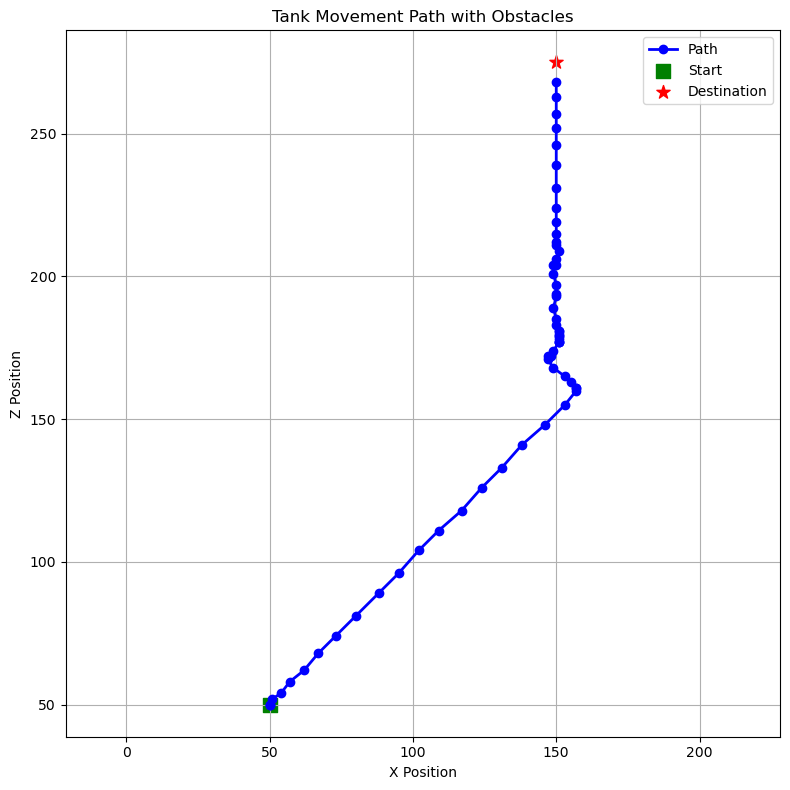

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

# 데이터 불러오기
df = pd.read_csv("tank_path0.csv")
maze = np.load("maze.npy")  # 저장된 장애물 정보
x_path = df["x"]
z_path = df["z"]

# 시작/도착 지점
start_x, start_z = 50, 50
destination_x, destination_z = 150, 275

plt.figure(figsize=(8, 8))

# 장애물 시각화
obstacle_coords = np.argwhere(maze == 1)
if len(obstacle_coords) > 0:
    obs_x = obstacle_coords[:, 0]
    obs_z = obstacle_coords[:, 1]
    plt.scatter(obs_x, obs_z, color='black', s=10, label="Obstacle")

# 이동 경로
plt.plot(x_path, z_path, marker='o', color='blue', linewidth=2, label="Path")

# 시작점/도착점
plt.scatter(start_x, start_z, color='green', s=100, label="Start", marker='s')
plt.scatter(destination_x, destination_z, color='red', s=100, label="Destination", marker='*')

# 마무리
plt.title("Tank Movement Path with Obstacles")
plt.xlabel("X Position")
plt.ylabel("Z Position")
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.savefig("tank_path_with_obstacles.png")
plt.show()


# 이동 경로 그림 그릴 때 필요함.
current_position = None
last_position = None
position_history = []

# /get action 안에 넣을 것

#     if current_grid:
#         last_position = current_grid
#     position_history.append(current_grid)
    
#     df = pd.DataFrame(position_history, columns=["x", "z"])
#     df.to_csv("tank_path0.csv", index=False)